# Part1: Preprossing The Dataset


## Importing Libraries And Loading The Dataset

In [3]:
! pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install opendatasets
# Data Manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


import opendatasets as od
import os
from datetime import datetime

from bs4 import BeautifulSoup

import string
import re

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier



In [171]:
import nltk
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [172]:
od.download_kaggle_dataset("https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews" , "data")

Skipping, found downloaded files in "data/imdb-dataset-of-50k-movie-reviews" (use force=True to force download)


In [173]:
for dirpath, dirnames ,  filenames in os.walk("/content/data"):
    print(f"there is {len(dirnames)} dirs and {len(filenames)} files in {dirpath}")

there is 1 dirs and 0 files in /content/data
there is 0 dirs and 1 files in /content/data/imdb-dataset-of-50k-movie-reviews


In [174]:
df = pd.read_csv("/content/data/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df_copy = df.copy()

## Exploring The Dataset

In [175]:
df_copy.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [176]:
df_copy.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


I think we have some duplicated reviews in the dataset

In [177]:
df_copy["dub"] = df_copy.duplicated()

In [178]:
df_unique = df_copy[df_copy["dub"] == False]

In [179]:
df_unique.describe()

,review,sentiment,dub
count,49582,49582,49582
unique,49582,2,1
top,One of the other reviewers has mentioned that ...,positive,False
freq,1,24884,49582


In [180]:
df_unique["sentiment"].value_counts(), df_copy["sentiment"].value_counts()

(positive    24884
 negative    24698
 Name: sentiment, dtype: int64, positive    25000
 negative    25000
 Name: sentiment, dtype: int64)

In [181]:
df_copy.groupby("sentiment").count()

,review,dub
sentiment,,
negative,25000,25000
positive,25000,25000


I will work with df_copy because it is balaneced unlike df_unique

### Visualise Some Reviews

In [182]:
for _ in range(5):
  rand = random.randint(0,len(df_copy))
  senti = df_copy["sentiment"][rand]
  rev = df_copy["review"][rand]
  print(f"""
  The Review :
  {rev}
  Seniment:
  {senti}
  """)



  The Review :
  OK,but does that make this a good movie?well,not really,in my opinion.there isn't a whole lot to recommend it.i found it very slow,tediously,in fact.it's also predictable pretty much through and through.number one and two were somewhat predictable,but not as much.i also felt this movie was quite campy at times,which i didn't really think fits this series and the character.Jeff Fahey plays the main bad guy in this installment.he's a decent enough actor,but i felt he played his character too over the top.i guess that fit with the tone of the movie,which would have been great if i had liked the movie.plus,there were some pretty bad one liners.Arnold Vosloo returns in the title role,but is given little to work with in this movie.the character has not really evolved,as i had hoped.oh well.this is just my opinion.anyway,for me,while this movie is not abysmal,it is pretty bad.my vote for Darkman III: 3.5/5
  Seniment:
  negative
  

  The Review :
  Back in the day of the bi

## Preprocessing The Texts

picking one value to test on

### Removing HTML Tags

In [183]:
value = df_copy.iloc[0]

In [184]:
value["review"]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [185]:
bs = BeautifulSoup(value["review"],"html.parser" )
value_no_html = bs.get_text()

### Removing Punctotion And Numbers

In [186]:
value_no_html

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wo

In [187]:
cleaned_text = value_no_html.translate(str.maketrans("","", string.punctuation+string.digits))
cleaned_text

'One of the other reviewers has mentioned that after watching just  Oz episode youll be hooked They are right as this is exactly what happened with meThe first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO Trust me this is not a show for the faint hearted or timid This show pulls no punches with regards to drugs sex or violence Its is hardcore in the classic use of the wordIt is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary It focuses mainly on Emerald City an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda Em City is home to manyAryans Muslims gangstas Latinos Christians Italians Irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayI would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare Forget pretty picture

Removing Stopwords

In [188]:
stopwords.words("english")[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [189]:
stopwords = stopwords.words("english")

In [190]:
[word for word in cleaned_text.split() if word not in stopwords ][1:10]

['reviewers',
 'mentioned',
 'watching',
 'Oz',
 'episode',
 'youll',
 'hooked',
 'They',
 'right']

well done!
we are ready now to create our cleaning function

In [191]:
def delta_time():
  t_1 = datetime.now()
  [word for word in cleaned_text.split() if word not in stopwords ]
  t_2 = datetime.now()
  [word for word in cleaned_text.split() if word not in set(stopwords) ]
  t_3 = datetime.now()
  return t_2-t_1, t_3-t_2

delte1 , delta2 = delta_time()

In [192]:
delte1 , delta2

(datetime.timedelta(microseconds=1106), datetime.timedelta(microseconds=1491))

i will use set() as a data structure to look up faster. it is not very fast for one value but it will be faster when i apply it to the whole dataset

### Cleaning Function

In [193]:
def clean_text(text):
  bs = BeautifulSoup(text,"html.parser" )
  value_no_html = bs.get_text()
  cleaned_text = value_no_html.translate(str.maketrans("","", string.punctuation+string.digits))
  text = [word for word in cleaned_text.split() if word not in set(stopwords) ]
  return " ".join(text)

### Appling The clean_text Function

In [203]:
clean_text("The cat stretched. Jacob stood on his tiptoes. She opened the door.Kelly twirled in circles. ".lower())

'cat stretched jacob stood tiptoes opened doorkelly twirled circles'

It works very good

In [ ]:
df_copy["review"] = df_copy["review"].apply(lambda x : clean_text(x))

In [196]:
for _ in range(5):
  rand = random.randint(0,len(df_copy))
  senti = df_copy["sentiment"][rand]
  rev = df_copy["review"][rand]
  print(f"""
  The Review :
  {rev}
  Seniment:
  {senti}
  """)
  


  The Review :
  I liked Timothy Dalton much even though bit young handsome Mr R I thought Zelah Clarke plump short This version however true novel well filmed I seen versions Orson Welles still favorite Mr R though George C Scott well toss Joan Fontaine Sussanah York although bit old role I recently saw brilliant TV version Rebecca Charles Dance Emilia Fox I would love see two Jane EyreBy time I got watching Ciarin Hinds version I think I Jane Eyred I never tire first minutes hearing Joan Fontaines voice narrate opening first version I ever saw I always want go back read book
  Seniment:
  positive
  

  The Review :
  I saw posh movie theater audience usually white educated urban The showing I attended sprinkling AfricanAmericans made difference audiencereaction two groups wonderful social commentary state race relations country Basically white folks AFRAID laugh laughed nervously funny bits many theyd laughting Blacks Blacks also stayed pretty silent many couldnt laugh front whites

### Spilt to train, validation and test

I will be running a lot of experments so i will run it just to %10 of the dataset

In [204]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
 2   dub        50000 non-null  bool  
dtypes: bool(1), object(2)
memory usage: 830.2+ KB


In [205]:
df_shuffeled = df_copy.sample(frac=1) #shuffling the data

In [206]:
df_shuffeled.head()

,review,sentiment,dub
6701,A female friend currently drawn relationship S...,positive,False
48053,This movie recieved horrible ratings everyone ...,positive,False
7399,This astounding film As well showing actual fo...,positive,False
9782,I knew little movie I entered theatre advance ...,positive,False
10299,I love series Many stereotypes portraying Sout...,positive,False


In [207]:
df_10 = df_shuffeled[:5000]

In [209]:
df_10.head()

,review,sentiment,dub
6701,A female friend currently drawn relationship S...,positive,False
48053,This movie recieved horrible ratings everyone ...,positive,False
7399,This astounding film As well showing actual fo...,positive,False
9782,I knew little movie I entered theatre advance ...,positive,False
10299,I love series Many stereotypes portraying Sout...,positive,False


In [210]:
 print(len(df_10)/len(df_shuffeled))

0.1


In [211]:
x_train , x_test , y_train , y_test = train_test_split(df_10["review"],df_10["sentiment"], test_size=0.2 , shuffle= True )

In [212]:
len(x_train)

4000

In [213]:
x_train , x_valid , y_train , y_valid = train_test_split(x_train,y_train, test_size=0.1 , shuffle= True )

In [214]:
len(x_train),len(x_valid),len(x_test)

(3600, 400, 1000)

# Part2: Modeling

#### Tokenization using CountVectorizer

In [219]:
cv = CountVectorizer( 
    max_features= 10000,
    lowercase= True,
)
cv_train = cv.fit_transform(x_train)
cv_test = cv.transform(x_test)
cv_valid = cv.transform(x_valid)

now we can create our first model

In [220]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(cv_train , y_train)


LogisticRegression(max_iter=1000)

In [221]:
log_reg.score(cv_train , y_train)

0.9994444444444445

Evaluating the model

In [222]:
log_reg.score(cv_test,y_test)

0.82

In [223]:
# same result
(log_reg.predict(cv_test)==y_test).sum()/len(y_test)

0.82

In [226]:
baseline = pd.DataFrame({"Train":[log_reg.score(cv_train,y_train)],"Validation": [log_reg.score(cv_valid,y_valid)], "Test":[log_reg.score(cv_test,y_test)]}, index= ["baseline : just CountVectorizer"])

In [253]:
models_list = []
models_list.append(baseline)

In [254]:
models_list[0]

,Train,Validation,Test
baseline : just CountVectorizer,0.999444,0.8175,0.82


Not bad for our baseline model

## Model1 CountVectorizer using stemmer

---



In [230]:
#creating a stemmer class to use it in sklearn CountVectorizer
ps = PorterStemmer()
class stemmer:
  def __call__(self, doc):
    tokens = word_tokenize(doc)
    return [ps.stem(word) for word in tokens]

In [234]:
cv1 = CountVectorizer(
    lowercase= True,
    tokenizer= stemmer(),
    max_features= 10000

)
cv1_train = cv1.fit_transform(x_train)
cv1_test = cv1.transform(x_test)
cv1_valid = cv1.transform(x_valid)

In [266]:
# running the model
model_1 = LogisticRegression(max_iter = 1000)
model_1.fit(cv1_train , y_train)

LogisticRegression(max_iter=1000)

In [267]:
model_1 = pd.DataFrame({"Train":[model_1.score(cv1_train,y_train)],"Validation": [model_1.score(cv1_valid,y_valid)] ,"Test":[model_1.score(cv1_test,y_test)]} , index= ["Model 1 : CountVectorizer using Stemmer"])

In [268]:
models_list.append(model_1)

In [269]:
models = pd.concat(models_list, axis=0)

In [280]:
models

,Train,Validation,Test
baseline : just CountVectorizer,0.999444,0.8175,0.820
Model 1 : CountVectorizer using Stemmer,0.480833,0.4325,0.496
Model 1 : CountVectorizer using Stemmer,0.999444,0.8200,0.826


## Model2 CountVectorizer using lemmetizer


In [260]:
wnl = WordNetLemmatizer()

In [261]:
def lemma_pos(pos_tag):
  if pos_tag.startswith("N"):
    return "n"
  elif pos_tag.startswith("V"):
    return "v"
  elif pos_tag.startswith("J"):
    return "r"
  elif pos_tag.startswith("R"):
    return "r"
  else: return "n"

In [262]:
class lemmatize:
  def __call__(self,doc):
    tokens = word_tokenize(doc)
    word_dict = pos_tag(tokens)
    return [wnl.lemmatize(word,lemma_pos(tag)) for word,tag in word_dict]

In [264]:
cv2 = CountVectorizer(
    max_features= 10000,
    lowercase= True,
    tokenizer= lemmatize()
)
cv2_train = cv2.fit_transform(x_train)
cv2_test = cv2.transform(x_test)
cv2_valid = cv2.transform(x_valid)

In [320]:
# running the model
model_2 = LogisticRegression(max_iter = 1000)
model_2.fit(cv2_train , y_train)

LogisticRegression(max_iter=1000)

In [321]:
model_2.score(cv2_train , y_train)

0.9994444444444445

In [322]:
model_2 = pd.DataFrame({"Train":[model_2.score(cv2_train,y_train)],"Validation": [model_2.score(cv2_valid,y_valid)] ,"Test":[model_2.score(cv2_test,y_test)]} , index= ["Model 2 : CountVectorizer using lemmetizer"])

In [323]:
models_list.append(model_2)

In [324]:
pd.concat(models_list, axis=0)

,Train,Validation,Test,test
baseline : just CountVectorizer,0.999444,0.8175,0.820,NaN
Model 1 : CountVectorizer using Stemmer,0.999444,0.8200,0.826,NaN
Model 1 : CountVectorizer using Stemmer,0.510556,0.4900,0.524,NaN
Model 1 : CountVectorizer using Stemmer,0.510556,0.4900,0.524,NaN
Model 2 : CountVectorizer using lemmetizer,0.510556,0.4900,0.524,NaN
Model 3 : TFIDFVectorizer,0.947500,0.8600,NaN,0.843
Model 3 : TFIDFVectorizer,0.947500,0.8600,NaN,0.843
Model 3 : TFIDFVectorizer,0.947500,0.8600,0.843,NaN
Model 3 : TFIDFVectorizer,0.947500,0.8600,0.843,NaN
Model 2 : CountVectorizer using lemmetizer,0.999444,0.8100,0.827,NaN


## Model3 TFIDF

In [298]:
tf_idf = TfidfVectorizer(lowercase = True , max_features=10000)
tf_train = tf_idf.fit_transform(x_train)
tf_test = tf_idf.transform(x_test)
tf_valid = tf_idf.transform(x_valid)

In [311]:
model_3 = LogisticRegression(max_iter = 1000)
model_3.fit(tf_train , y_train)

LogisticRegression(max_iter=1000)

In [313]:
model_3 = pd.DataFrame({"Train":[model_3.score(tf_train,y_train)],"Validation": [model_3.score(tf_valid,y_valid)], "Test":[model_3.score(tf_test,y_test)]} , index= ["Model 3 : TFIDFVectorizer "])

In [316]:
models_list.append(model_3)

In [317]:
models = pd.concat([models,model_3])

In [318]:
models

,Train,Validation,Test,test
baseline : just CountVectorizer,0.999444,0.8175,0.820,NaN
Model 1 : CountVectorizer using Stemmer,0.480833,0.4325,0.496,NaN
Model 1 : CountVectorizer using Stemmer,0.999444,0.8200,0.826,NaN
Model 3 : TFIDFVectorizer,0.947500,0.8600,NaN,0.843
Model 3 : TFIDFVectorizer,0.947500,0.8600,NaN,0.843
Model 3 : TFIDFVectorizer,0.947500,0.8600,0.843,NaN
Model 3 : TFIDFVectorizer,0.947500,0.8600,0.843,NaN


## Model 4 : 

In [325]:
rf = RandomForestClassifier()
rf.fit(cv_train, y_train)

RandomForestClassifier()

In [326]:
rf.score(cv_train, y_train)

1.0

In [327]:
rf.score(cv_test, y_test)

0.818

In [337]:
rf1 = DecisionTreeClassifier()
rf1.fit(cv1_train, y_train)
rf1.score(cv1_train, y_train) ,rf1.score(cv1_valid, y_valid), rf1.score(cv1_test, y_test)

(1.0, 0.6875, 0.699)

In [336]:
rf2 = DecisionTreeClassifier()
rf2.fit(cv2_train, y_train)
rf2.score(cv2_train, y_train) ,rf2.score(cv2_valid, y_valid), rf2.score(cv2_test, y_test)

(1.0, 0.67, 0.731)

In [338]:
rf3 = DecisionTreeClassifier()
rf3.fit(tf_train, y_train)
rf3.score(tf_train, y_train) , rf3.score(tf_valid, y_valid),rf3.score(tf_test, y_test)

(1.0, 0.6725, 0.674)

# Part3: Modeling with Deep learning 

In [1]:
! pip install opendatasets
# Data Manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


import opendatasets as od
import os
from datetime import datetime
import string

from bs4 import BeautifulSoup

od.download_kaggle_dataset("https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews" , "data")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: 
Your Kaggle username: 
Your Kaggle username: 
Your Kaggle username: mahmoudatiaeadatia
Your Kaggle Key: ··········


100%|██████████| 25.7M/25.7M [00:02<00:00, 12.5MB/s]


In [2]:
df = pd.read_csv("/content/data/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df_copy = df.copy()

In [3]:
import string
import nltk
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('stopwords')
stopwords = stopwords.words("english")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub

In [5]:
def clean_text(text):
  bs = BeautifulSoup(text,"html.parser" )
  value_no_html = bs.get_text()
  cleaned_text = value_no_html.translate(str.maketrans("","", string.punctuation+string.digits))
 # text = [word for word in cleaned_text.split() if word not in set(stopwords) ]
  return cleaned_text

df_copy["review"] = df_copy["review"].apply(lambda x : clean_text(x))
df_shuffeled = df_copy.sample(frac=1) #shuffling the data
df_10 = df_shuffeled[:5000]

x_train , x_test , y_train , y_test = train_test_split(df_10["review"],df_10["sentiment"], test_size=0.2 , shuffle= True )
x_train , x_valid , y_train , y_valid = train_test_split(x_train,y_train, test_size=0.1 , shuffle= True )

Preparing our data for Deep Learning

### Create tensorflow datasets

mapping - caching - shuffeling - batching - prefeching

In [6]:
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_valid = le.transform(y_valid)
y_test = le.transform(y_test)

In [7]:
le.classes_

array(['negative', 'positive'], dtype=object)

In [8]:
one_hot = OneHotEncoder(sparse = False)
y_train_onehot = one_hot.fit_transform(np.reshape(np.array(y_train),(-1,1)))
y_test_onehot = one_hot.transform(np.reshape(np.array(y_test),(-1,1)))
y_valid_onehot = one_hot.transform(np.reshape(np.array(y_valid),(-1,1)))

In [9]:
train = tf.data.Dataset.from_tensor_slices((x_train,y_train))
test = tf.data.Dataset.from_tensor_slices((x_test,y_test))
valid = tf.data.Dataset.from_tensor_slices((x_valid,y_valid))

In [10]:

train = train.batch(32).prefetch(tf.data.AUTOTUNE)
test  = test.batch(32).prefetch(tf.data.AUTOTUNE)
valid = valid.batch(32).prefetch(tf.data.AUTOTUNE)

### Creating Text Vectorizer And Embeding Layer

In [11]:
# how many word do we have in a sentence on avrage?
words_len_list = [len(sent.split()) for sent in  x_train ]
np.mean(words_len_list)

225.17527777777778

ploting words count

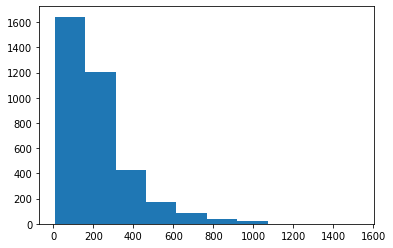

In [12]:
plt.hist(words_len_list);

In [13]:
max_words = int(np.quantile(words_len_list, q=0.95))+1 #most of the texts have less than 597 words
max_words

574

In [14]:
text_vectorizer = layers.TextVectorization(max_tokens= 100000, output_sequence_length= max_words )

In [15]:
text_vectorizer.adapt(x_train)

In [16]:
sent = random.choice(np.array(x_train))
print(f"""
Sentence length : {len(sent.split())}
Sentence : {sent}
Sentence Vector : {text_vectorizer([sent])}
Vector length : {len(text_vectorizer([sent])[0])}
""")


Sentence length : 289
Sentence : Ahem I think Ill be the only one whos saying this but yes I was a lil bored during the film Not to say that this is a bad movie in fact its a very good attempt at portraying the innermost emotions  dilemma sorrow love esp its the directors debut read from somewhere is it true I felt that somethings not quite right maybe its just me Im not drawn to the characters enough to immerse me in their world This is a simple story about ordinary people ordinary lives Through simple and short dialogs the director tries to relate a simple guys life and how copes with the news of his illness by laughing it away every time Oh ya his laughter was kinda cute at first but gradually it gets to me such a deep hearty roar for a gentle man I must say I didnt feel the impact that most readers felt in fact I was more drawn to the trivial scenarios like spitting of watermelon seeds with his sis that clearly shows that theyre comfortable with each other the granny who came back

In [17]:
print(f"""
Number of the tokens : {len(text_vectorizer.get_vocabulary())}
Most common words : {  text_vectorizer.get_vocabulary()[:20]}
least common words {  text_vectorizer.get_vocabulary()[-20:]}
  """)


Number of the tokens : 45148
Most common words : ['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'this', 'i', 'that', 'was', 'with', 'as', 'for', 'movie', 'but', 'film']
least common words ['abdicating', 'abdicates', 'abbottwe', 'abbotts', 'abbottcostello', 'abbey', 'abbe', 'abandoning', 'abahy', 'aarika', 'aargh', 'aaran', 'aapke', 'aan', 'aames', 'aaliyahs', 'aag', 'aaaggghhhhhhh', 'aaaahhhhhh', 'aaa']
  


Embding Layer

In [18]:
embed = layers.Embedding(
len(text_vectorizer.get_vocabulary()),
128,
mask_zero = True 
)

In [19]:
sent = random.choice(np.array(x_train))
print(f"""
Sentence length : {len(sent.split())}
Sentence : {sent}
Sentence emmbedings : {embed(text_vectorizer([sent]))}
shape : {embed(text_vectorizer([sent])).shape}
""")


Sentence length : 141
Sentence : If you have ever seen a Bollywood movie you know they are longer than most movies due to the multiple song and dance routines each one is over five minutes long Fortunately this one has fewer song and dance routines and fits into the standard movie length Dont get me wrong I like Bollywood movies but tend to fast forward through the song and dance portions I bought this DVD because I am an Ian Bohen fan Although his role wasnt as large as I hoped he still had a good amount of screen time And his character was much different than his other rolesOverall this was a good movie Like most Bollywood movies there is at least one element of controversyconflict of the traditional Indian culture But true love triumphs over adversity and a happy ending is had by all
Sentence emmbedings : [[[ 0.00566553 -0.04196159  0.04021401 ... -0.01943091  0.03849185
    0.0200487 ]
  [ 0.0247413  -0.0119198  -0.00524361 ...  0.04948625 -0.03723049
    0.01159314]
  [-0.0246942

### DL Model1 : Conv1D

In [20]:
input = layers.Input((1,), dtype= tf.string)
text_vectors = text_vectorizer(input)
embedings = embed(text_vectors)
x = layers.Conv1D(filters = 64, kernel_size = 5 , padding = "same", activation= "relu") (embedings)
x = layers.GlobalAveragePooling1D() (x)
output = layers.Dense(1, activation="sigmoid") (x)

dl_model1 = tf.keras.models.Model(input, output)

In [21]:
dl_model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 574)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 574, 128)          5778944   
                                                                 
 conv1d (Conv1D)             (None, 574, 64)           41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 65    

In [22]:
dl_model1.compile(
    loss = "binary_crossentropy",
    optimizer= "adam",
    metrics = "accuracy"
)

In [23]:
def checkpoint(model_name):
  return tf.keras.callbacks.ModelCheckpoint(("Experiments"+"/"+ model_name),save_best_only=True )

In [24]:
history1 = dl_model1.fit(train, 
                     epochs = 5,
                    validation_data = valid,
                     callbacks = [checkpoint("conv1d")])

Epoch 1/5
113/113 [==============================] - ETA: 0s - loss: 0.6650 - accuracy: 0.6086

113/113 [==============================] - 16s 24ms/step - loss: 0.6650 - accuracy: 0.6086 - val_loss: 0.5728 - val_accuracy: 0.7725
Epoch 2/5
113/113 [==============================] - ETA: 0s - loss: 0.3752 - accuracy: 0.8800

113/113 [==============================] - 2s 20ms/step - loss: 0.3752 - accuracy: 0.8800 - val_loss: 0.3672 - val_accuracy: 0.8500
Epoch 3/5
113/113 [==============================] - ETA: 0s - loss: 0.1477 - accuracy: 0.9642

113/113 [==============================] - 2s 20ms/step - loss: 0.1477 - accuracy: 0.9642 - val_loss: 0.3332 - val_accuracy: 0.8825
Epoch 4/5
113/113 [==============================] - 1s 10ms/step - loss: 0.0603 - accuracy: 0.9908 - val_loss: 0.3507 - val_accuracy: 0.8875
Epoch 5/5
113/113 [==============================] - 1s 10ms/step - loss: 0.0281 - accuracy: 0.9967 - val_loss: 0.3809 - val_accuracy: 0.8850


In [25]:
dl_model1 = tf.keras.models.load_model("/content/Experiments/conv1d")

In [26]:
dl_model1.evaluate(valid)

13/13 [==============================] - 0s 4ms/step - loss: 0.3332 - accuracy: 0.8825


[0.33315807580947876, 0.8824999928474426]

In [27]:
preds = dl_model1.predict(test)

32/32 [==============================] - 0s 3ms/step


In [28]:
print(confusion_matrix(y_test, np.round(preds)))

[[428  51]
 [ 80 441]]


In [29]:
print( f"Acuracy : {(432+424) / len(y_test)}" )

Acuracy : 0.856


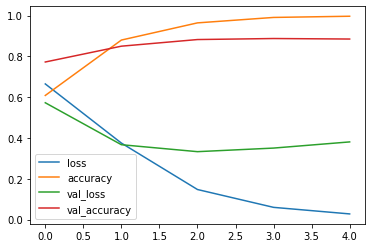

In [30]:
pd.DataFrame(history1.history).plot()

In [31]:
dl_model_1 = pd.DataFrame({"Train":[dl_model1.evaluate(train)[1]],"Validation": [dl_model1.evaluate(valid)[1]], "Test":[dl_model1.evaluate(test)[1]]} , index= ["DL Model 1 : Conv1D "])

32/32 [==============================] - 0s 5ms/step - loss: 0.3233 - accuracy: 0.8690


In [32]:
dl_model_1

,Train,Validation,Test
DL Model 1 : Conv1D,0.989167,0.8825,0.869


## DL Model2 : Conv1D with pretrained word embedings

In [33]:
use_embed_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                 trainable= False) #

In [34]:
input = layers.Input([], dtype= tf.string) # an empty list following the documentation
embedings = use_embed_layer(input )
x = layers.Dense(64, activation="relu") (embedings)
output = layers.Dense(1, activation="sigmoid") (x)

dl_model2 = tf.keras.models.Model(input, output)

In [35]:
dl_model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [36]:
dl_model2.compile(
    loss = "binary_crossentropy",
    optimizer= "adam",
    metrics = "accuracy"
)

In [37]:
history2 = dl_model2.fit(train, 
                     epochs = 5,
                    validation_data = valid,
                     callbacks = [checkpoint("use_embedings")])

Epoch 1/5
113/113 [==============================] - 19s 135ms/step - loss: 0.5571 - accuracy: 0.7736 - val_loss: 0.4350 - val_accuracy: 0.8300
Epoch 2/5
113/113 [==============================] - 14s 127ms/step - loss: 0.3777 - accuracy: 0.8497 - val_loss: 0.3575 - val_accuracy: 0.8475
Epoch 3/5
113/113 [==============================] - 13s 116ms/step - loss: 0.3352 - accuracy: 0.8603 - val_loss: 0.3371 - val_accuracy: 0.8500
Epoch 4/5
113/113 [==============================] - 14s 121ms/step - loss: 0.3197 - accuracy: 0.8661 - val_loss: 0.3289 - val_accuracy: 0.8550
Epoch 5/5
113/113 [==============================] - 14s 120ms/step - loss: 0.3112 - accuracy: 0.8694 - val_loss: 0.3252 - val_accuracy: 0.8575


In [38]:
dl_model2.evaluate(test)

32/32 [==============================] - 2s 73ms/step - loss: 0.3194 - accuracy: 0.8560


[0.3193615972995758, 0.8560000061988831]

In [39]:
input = layers.Input((1,), dtype= tf.string)
text_vectors = text_vectorizer(input)
embedings = embed(text_vectors)
x = layers.LSTM(64) (embedings)
output = layers.Dense(1, activation="sigmoid") (x)

dl_model3 = tf.keras.models.Model(input, output)

In [40]:
dl_model3.compile(
    loss = "binary_crossentropy",
    optimizer= "adam",
    metrics = "accuracy"
)

In [41]:
history3 = dl_model3.fit(train, 
                     epochs = 5,
                    validation_data = valid,
                     callbacks = [checkpoint("LSTM")])

Epoch 1/5
112/113 [============================>.] - ETA: 0s - loss: 0.2051 - accuracy: 0.9272

113/113 [==============================] - 20s 133ms/step - loss: 0.2043 - accuracy: 0.9275 - val_loss: 0.4792 - val_accuracy: 0.8425
Epoch 2/5
113/113 [==============================] - 4s 31ms/step - loss: 0.0547 - accuracy: 0.9867 - val_loss: 0.6044 - val_accuracy: 0.8325
Epoch 3/5
113/113 [==============================] - 3s 30ms/step - loss: 0.0210 - accuracy: 0.9956 - val_loss: 0.8000 - val_accuracy: 0.8125
Epoch 4/5
113/113 [==============================] - 3s 30ms/step - loss: 0.0101 - accuracy: 0.9978 - val_loss: 0.6816 - val_accuracy: 0.8525
Epoch 5/5
113/113 [==============================] - 3s 30ms/step - loss: 0.0211 - accuracy: 0.9947 - val_loss: 0.7259 - val_accuracy: 0.8225


### Picking a Model

In [42]:
x_train , x_test , y_train , y_test = train_test_split(df_copy["review"],df_copy["sentiment"], test_size=0.2 , shuffle= True )
x_train , x_valid , y_train , y_valid = train_test_split(x_train,y_train, test_size=0.1 , shuffle= True )

In [43]:
len(x_valid)

4000

In [44]:
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_valid = le.transform(y_valid)
y_test = le.transform(y_test)

In [45]:
train = tf.data.Dataset.from_tensor_slices((x_train,y_train))
test = tf.data.Dataset.from_tensor_slices((x_test,y_test))
valid = tf.data.Dataset.from_tensor_slices((x_valid,y_valid))
train = train.batch(32).prefetch(tf.data.AUTOTUNE)
test  = test.batch(32).prefetch(tf.data.AUTOTUNE)
valid = valid.batch(32).prefetch(tf.data.AUTOTUNE)

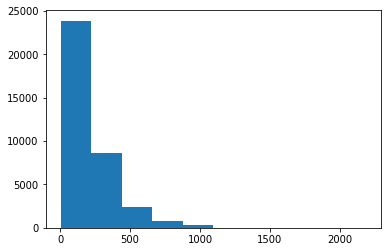

In [46]:
words_len_list = [len(sent.split()) for sent in  x_train ]
np.mean(words_len_list)
plt.hist(words_len_list);

In [47]:
max_words = int(np.quantile(words_len_list, q=0.95))+1 #most of the texts have less than 597 words
max_words

577

In [48]:
text_vectorizer = layers.TextVectorization(max_tokens= 1000000, output_sequence_length= max_words )
text_vectorizer.adapt(x_train)

In [49]:
print(f"""
Number of the tokens : {len(text_vectorizer.get_vocabulary())}
Most common words : {  text_vectorizer.get_vocabulary()[:20]}
least common words {  text_vectorizer.get_vocabulary()[-20:]}
  """)


Number of the tokens : 175566
Most common words : ['', '[UNK]', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'it', 'this', 'i', 'that', 'was', 'as', 'with', 'for', 'movie', 'but', 'film']
least common words ['aagh', 'aadmittedly', 'aada', 'aab', 'aaarrrghim', 'aaand', 'aaahthe', 'aaahhhhhhh', 'aaaggghhhhhhh', 'aaaawwwwww', 'aaaarrgh', 'aaaaaw', 'aaaaatchkah', 'aaaaarrrrrrgggggghhhhhh', 'aaaaargh', 'aaaaah', 'aaaaaaahhhhhhggg', 'aaaaaaah', 'aaaaaaaaaaaahhhhhhhhhhhhhh', '\x10own']
  


In [50]:
embed = layers.Embedding(
len(text_vectorizer.get_vocabulary()),
128,
mask_zero = True 
)

In [51]:
input = layers.Input((1,), dtype= tf.string)
text_vectors = text_vectorizer(input)
embedings = embed(text_vectors)
x = layers.Conv1D(filters = 64, kernel_size = 5 , padding = "same", activation= "relu") (embedings)
x = layers.GlobalAveragePooling1D() (x)
output = layers.Dense(1, activation="sigmoid") (x)

dl_model1_all = tf.keras.models.Model(input, output)

In [56]:
dl_model1_all.compile(
    loss = "binary_crossentropy",
    optimizer= tf.keras.optimizers.Adam(0.00001),
    metrics = "accuracy"
)

In [57]:
history1_all = dl_model1_all.fit(train, 
                     epochs = 10,
                    validation_data = valid,
                     callbacks = [checkpoint("conv1d_all")])

Epoch 1/10
1124/1125 [============================>.] - ETA: 0s - loss: 0.0033 - accuracy: 0.9995

1125/1125 [==============================] - 23s 20ms/step - loss: 0.0033 - accuracy: 0.9995 - val_loss: 0.5264 - val_accuracy: 0.8915
Epoch 2/10
1125/1125 [==============================] - 21s 18ms/step - loss: 0.0032 - accuracy: 0.9995 - val_loss: 0.5300 - val_accuracy: 0.8913
Epoch 3/10
1125/1125 [==============================] - 20s 18ms/step - loss: 0.0031 - accuracy: 0.9996 - val_loss: 0.5337 - val_accuracy: 0.8907
Epoch 4/10
1125/1125 [==============================] - 20s 18ms/step - loss: 0.0030 - accuracy: 0.9996 - val_loss: 0.5373 - val_accuracy: 0.8907
Epoch 5/10
1125/1125 [==============================] - 25s 22ms/step - loss: 0.0029 - accuracy: 0.9997 - val_loss: 0.5410 - val_accuracy: 0.8905
Epoch 6/10
1125/1125 [==============================] - 20s 18ms/step - loss: 0.0028 - accuracy: 0.9997 - val_loss: 0.5446 - val_accuracy: 0.8910
Epoch 7/10
1125/1125 [==============================] - 20s 18ms/step - loss: 0.0027 - accuracy: 0.9997 - val_loss: 0.5483 - val_accura

In [ ]:
tf.keras.models.

In [58]:
preds =(dl_model1_all.predict(test))

313/313 [==============================] - 1s 4ms/step


In [59]:
{"Reviews":np.array( x_test),"Probs":((tf.squeeze(preds)) ),"Y_preds": tf.squeeze(np.round(preds)), "Y_true": y_test}

{'Reviews': array(['I have never before voted  for a movie on the IMDB but for this one I am sorry the scale doesnt go down to All I can say abou this movie is that I saw it in a Sneak Preview and it was my worst movie experience ever I dont mind the stupid jokes I can live with the silly story But when I see those dumbly grinning main characters with their pseudoforeign speech only Germans will understand what I talk about I felt I kind of loathing I never thought I was capable of If they had left them out the thing may actually have been acceptableTheres not much more to be said about this one You may laugh once or twice because its so ridiculous but that doesnt make it any better It is definitely not funnyIf you live outside of Germany be happy and rejoice that this awful work will most likely never make it to your cinemasIf you do live in Germany avoid this movie at all costs',
        'Yahoo Serious is like a  bottle of wine  had no substance to begin with and just gets worse with

In [60]:
df = pd.DataFrame({"Reviews":( x_test),"Probs":(np.round(tf.squeeze((preds)),6) ),"Y_preds": tf.squeeze(np.round(preds)), "Y_true": y_test})

In [61]:
most_wrong_values = df[df["Y_preds"]!=df["Y_true"]].sort_values(by="Probs" ,ascending=False)

In [62]:
most_wrong_values

,Reviews,Probs,Y_preds,Y_true
8430,Many of the lead characters in Hideo Goshas f...,1.0,1.0,0
2972,Robert Taylor definitely showed himself to be ...,1.0,1.0,0
43084,and in no way as clean logical and understand...,1.0,1.0,0
48457,Sherlock Holmes and the Secret Weapon starts i...,1.0,1.0,0
5375,Welcome to Our Town welcome to your town As we...,1.0,1.0,0
...,...,...,...,...
44887,I finally saw LAURE and I have to say that I e...,0.0,0.0,1
4020,black tar cant be snorted theres a documentary...,0.0,0.0,1
3735,Hardly a masterpiece Not so well written Beaut...,0.0,0.0,1
37788,After viewing several episodes of this series ...,0.0,0.0,1


In [63]:
most_wrong_values["Reviews"].iloc[0]

'Many of the lead characters in Hideo Goshas  film Hitokiri manslayer aka Tenchu  heavens punishment were actual historical figures in western nameorder format Ryoma Sakamoto Hampeita Takechi Shimbei Tanaka Izo Okada  Anenokoji The name Hitokiri a historical term refers to a group of four superswordsmen who carried out numerous assassinations of key figures in the ruling Tokugawa Shogunate in the mids under the orders of Takechi the leader of the Loyalist ie ultranationalist proEmperor faction of the Tosa clan What was this struggle about Sad to say you wont find out in this film Brilliant History Lesson indeedNo Gosha is much more interested in showing you the usual bloody slicing and dicing and at absurd length the inner torment of the notverybright killer Izo Okada than in revealing actual history Sakamoto for example was someone of historical significance considered to be the father of the Imperial Japanese Navy The closest Gosha comes to providing a history lesson is the scene in 

In [64]:
for i in range(5):
  print (f"""
  Reveiw : {most_wrong_values["Reviews"].iloc[i]}
  true label : {most_wrong_values["Y_true"].iloc[i]}
  predicted : {most_wrong_values["Y_preds"].iloc[i]}
  probabilty : {most_wrong_values["Probs"].iloc[i]}

  """)


  Reveiw : Many of the lead characters in Hideo Goshas  film Hitokiri manslayer aka Tenchu  heavens punishment were actual historical figures in western nameorder format Ryoma Sakamoto Hampeita Takechi Shimbei Tanaka Izo Okada  Anenokoji The name Hitokiri a historical term refers to a group of four superswordsmen who carried out numerous assassinations of key figures in the ruling Tokugawa Shogunate in the mids under the orders of Takechi the leader of the Loyalist ie ultranationalist proEmperor faction of the Tosa clan What was this struggle about Sad to say you wont find out in this film Brilliant History Lesson indeedNo Gosha is much more interested in showing you the usual bloody slicing and dicing and at absurd length the inner torment of the notverybright killer Izo Okada than in revealing actual history Sakamoto for example was someone of historical significance considered to be the father of the Imperial Japanese Navy The closest Gosha comes to providing a history lesson is th

In [71]:
for i in range(5):
  print (f"""
  Reveiw : {most_wrong_values["Reviews"].iloc[-i]}
  true label : {most_wrong_values["Y_true"].iloc[-i]}
  predicted : {most_wrong_values["Y_preds"].iloc[-i]}
  probabilty : {most_wrong_values["Probs"].iloc[-i]}

  """)


  Reveiw : Many of the lead characters in Hideo Goshas  film Hitokiri manslayer aka Tenchu  heavens punishment were actual historical figures in western nameorder format Ryoma Sakamoto Hampeita Takechi Shimbei Tanaka Izo Okada  Anenokoji The name Hitokiri a historical term refers to a group of four superswordsmen who carried out numerous assassinations of key figures in the ruling Tokugawa Shogunate in the mids under the orders of Takechi the leader of the Loyalist ie ultranationalist proEmperor faction of the Tosa clan What was this struggle about Sad to say you wont find out in this film Brilliant History Lesson indeedNo Gosha is much more interested in showing you the usual bloody slicing and dicing and at absurd length the inner torment of the notverybright killer Izo Okada than in revealing actual history Sakamoto for example was someone of historical significance considered to be the father of the Imperial Japanese Navy The closest Gosha comes to providing a history lesson is th

In [84]:
dl_model1_all.evaluate(test)

313/313 [==============================] - 2s 7ms/step - loss: 0.5607 - accuracy: 0.8836


[0.5607184767723083, 0.8835999965667725]